In [18]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]   

In [19]:
#Correlation matrix of 100 stocks based on their sector structure

def tanh(x):
    for (k,i,j) in product(range(0,61), range(0,100), range(0,100)):
        x[k][i][j] = np.tanh(x[k][i][j])


def daily_correlation(sigma):
    daily_corr = np.zeros((61, 100, 100))
    for (i, j) in product (range(0,100), range(0,100)):
        if (i>j):
            daily_corr[0][i][j] = np.random.normal(M2_S[i/10][j/10], sigma, 1)
            daily_corr[0][j][i] = daily_corr[0][i][j]
        else:
            if (i==j):
                daily_corr[0][i][j] = 1.0
        for k in range(1, 61):
            if (i>j):
                daily_corr[k][i][j] = np.random.normal(daily_corr[k-1][i][j], sigma, 1)
                daily_corr[k][j][i] = daily_corr[k][i][j]
            else:
                if (i==j):
                    daily_corr[k][i][j] = 1.0  
    tanh(daily_corr)
    return daily_corr

daily_corr = daily_correlation(0.3)




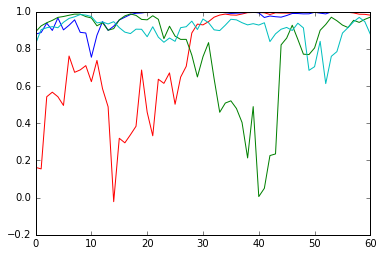

In [20]:
 #Plots showing evolution of the correlations between some stocks
def plots(daily_corr):       
    a,b,c,d = [],[],[],[]
    for i in range (0,61):
        a.append(daily_corr[i][9][94])
        b.append(daily_corr[i][97][95])
        c.append(daily_corr[i][10][11])
        d.append(daily_corr[i][10][12])

    plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
    plt.show()

    
plots(daily_corr)

In [21]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples, daily_corr):
    mu = np.zeros(100)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns

In [22]:
#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples, daily_corr):
    r0, r1 = return_generator(N_samples, daily_corr)
    model1 = []
    model2 = np.zeros((N_samples, 100, 100))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,10), range(0,10)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for (i,j) in product(range(0,100), range(0,100)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    


In [23]:
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,100):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,100):
        s = np.dot(matrix[i], x)+matrix[i][i]*x[i]
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x

In [24]:
#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
N_samples = 1200
m2 = np.identity(100)
def error(x, sample_or_not, range_of_sample):
    if (sample_or_not=='sample'):
        boundary0 = 1000 - range_of_sample
        boundary1 = 1000
    if (sample_or_not=='out_of_sample'):
        boundary0 = 1000
        boundary1 = 1200
    portfolio_returns = []
    for k in range (boundary0, boundary1):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 100)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)

In [25]:
#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(a):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=('sample', a), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun


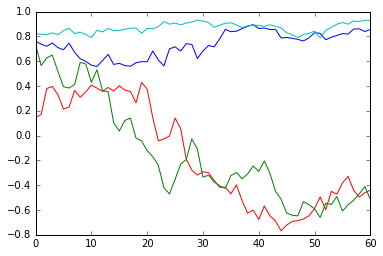

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.


0:42:21.477000 [ 0.51161008  0.48838764] 0.0337060754337
0.0373915429783


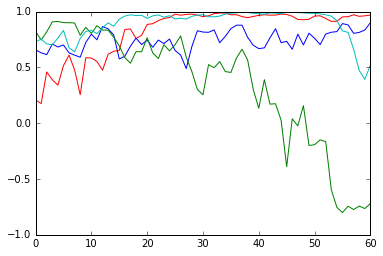

0:20:48.093000 [  9.99796190e-01   3.32930424e-06] 0.0340965998898
0.0392871325427


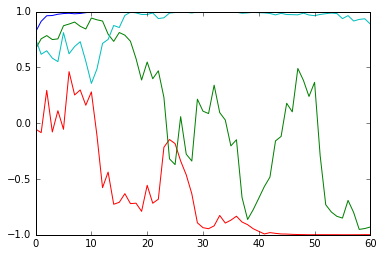

0:23:31.630000 [ 0.92534972  0.07458455] 0.0360549148861
0.0384276502779


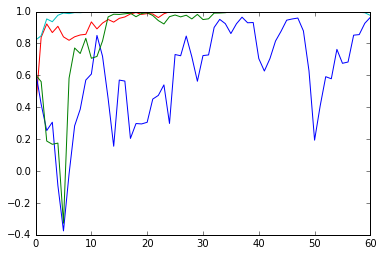

0:25:50.500000 [ 0.96312714  0.03687286] 0.0295387842094
0.0283739483583


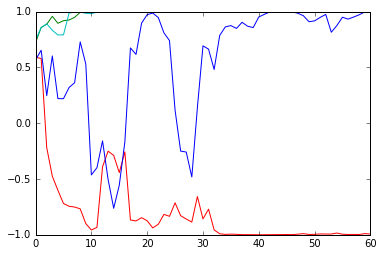

0:21:18.989000 [ 0.84869876  0.1206494 ] 0.0447608018639
0.0377499438925


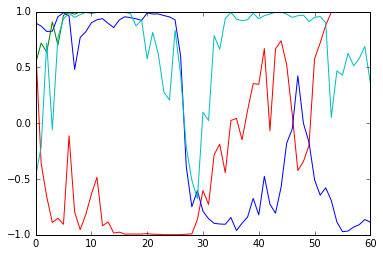

0:18:32.328000 [ 0.70171157  0.29828843] 0.0351055018991
0.0348158443784


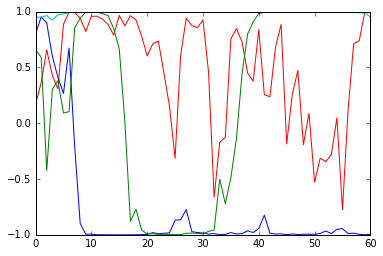

0:17:52.056000 [ 0.69395147  0.28932859] 0.0357576332267
0.038982930079


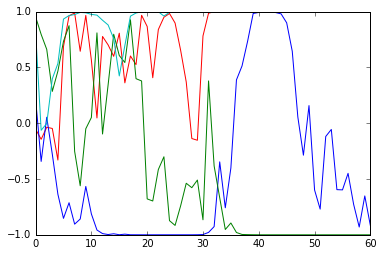

0:16:53.714000 [ 0.72106591  0.20911096] 0.0470206185715
0.0499452151198


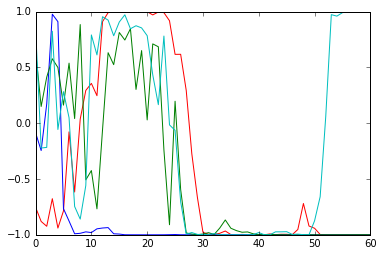

0:18:06.112000 [ 0.55659134  0.00340873] 0.0321831227679
0.0311895437036


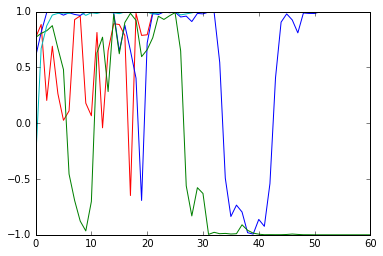

0:21:18.340000 [ 0.7086023  0.2913977] 0.0458470770375
0.0464568526639


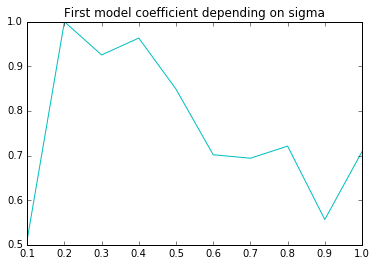

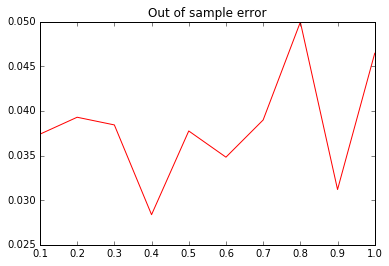

In [26]:
times = []
results = []
sample_error = []
out_of_sample_error = []
sigma_values = np.linspace(0.1, 1.0, 10)
for sigma in sigma_values:
    daily_corr = daily_correlation(sigma)
    plots(daily_corr)
    m0, m1, r1 = empiric_models(N_samples, daily_corr)
    time, result, err = optimal_model_weights(1000)
    sample_error.append(err)
    results.append([result[0], result[1], 1-result[0]-result[1]])
    times.append(time)
    print time, result, err
    e = error(result, 'out_of_sample', 100)
    print e
    out_of_sample_error.append(e)

a = []
for i in range(0,10):
    a.append(results[i][0])
    
plt.plot(sigma_values, a, 'c')
plt.title('First model coefficient depending on sigma')
plt.show()
 
#Graph showing evolution of error on the out_of_sample depending on the range_of_sample
plt.plot(sigma_values, out_of_sample_error, 'r')
plt.title('Out of sample error')
plt.show()

In [27]:
print times
print results
print sample_error
print out_of_sample_error


[datetime.timedelta(0, 2541, 477000), datetime.timedelta(0, 1248, 93000), datetime.timedelta(0, 1411, 630000), datetime.timedelta(0, 1550, 500000), datetime.timedelta(0, 1278, 989000), datetime.timedelta(0, 1112, 328000), datetime.timedelta(0, 1072, 56000), datetime.timedelta(0, 1013, 714000), datetime.timedelta(0, 1086, 112000), datetime.timedelta(0, 1278, 340000)]
[[0.51161008433731725, 0.48838763771418237, 2.2779485003843192e-06], [0.99979619019086274, 3.3293042416669835e-06, 0.00020048050489558945], [0.92534971732225813, 0.07458455097028116, 6.5731707460714439e-05], [0.96312714349698558, 0.036872856503014369, 4.8572257327350599e-17], [0.84869876264107258, 0.12064939997815458, 0.030651837380772845], [0.70171157146866159, 0.29828842853133841, 0.0], [0.69395147464738982, 0.28932859183177917, 0.01671993352083101], [0.72106590802871118, 0.20911095988910541, 0.069823132082183409], [0.55659134347945749, 0.0034087336005134885, 0.43999992292002904], [0.70860229962631593, 0.29139770037368401

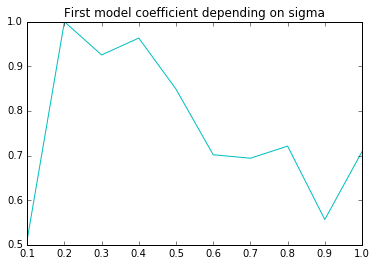

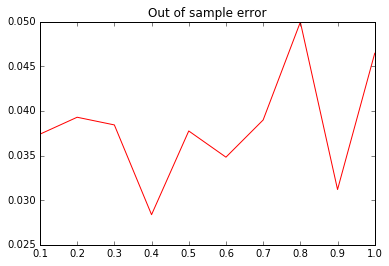

In [28]:

a = []
for i in range(0,10):
    a.append(results[i][0])
    
plt.plot(sigma_values, a, 'c')
plt.title('First model coefficient depending on sigma')
plt.show()
 
#Graph showing evolution of error on the out_of_sample depending on the range_of_sample
plt.plot(sigma_values, out_of_sample_error, 'r')
plt.title('Out of sample error')
plt.show()

In [29]:
print a

[0.51161008433731725, 0.99979619019086274, 0.92534971732225813, 0.96312714349698558, 0.84869876264107258, 0.70171157146866159, 0.69395147464738982, 0.72106590802871118, 0.55659134347945749, 0.70860229962631593]
